In [1]:
#default_exp music_transformer.transform

In [2]:
#export
from musicautobot.numpy_encode import *
from musicautobot.vocab import *

import music21
import numpy as np
from enum import Enum
import torch
from functools import partial

SEQType = Enum('SEQType', 'Mask, Sentence, Melody, Chords, Empty')

class MusicItem():
    def __init__(self, data, vocab, stream=None, position=None):
        self.data = data
        self.vocab = vocab
        self._stream = stream
        self._position = position
    def __repr__(self): return '\n'.join([
        f'\n{self.__class__.__name__} - {self.data.shape}',
        f'{self.vocab.textify(self.data[:10])}...'])
    def __len__(self): return len(self.data)

    @classmethod
    def from_file(cls, midi_file, vocab): 
        return cls.from_stream(file2stream(midi_file), vocab)
    @classmethod
    def from_stream(cls, stream, vocab):
        if not isinstance(stream, music21.stream.Score): stream = stream.voicesToParts()
        chordarr = stream2chordarr(stream) # 2.
        npenc = chordarr2npenc(chordarr) # 3.
        return cls.from_npenc(npenc, vocab, stream)
    @classmethod
    def from_npenc(cls, npenc, vocab, stream=None): return MusicItem(npenc2idxenc(npenc, vocab), vocab, stream)
    
    @classmethod
    def from_idx(cls, item, vocab):
        idx,pos = item
        return MusicItem(idx, vocab=vocab, position=pos)
    def to_idx(self): return self.data, self.position
    
    @classmethod
    def empty(cls, vocab, seq_type=SEQType.Sentence):
        return MusicItem(seq_prefix(seq_type, vocab), vocab)

    @property
    def stream(self):
        self._stream = self.to_stream() if self._stream is None else self._stream
        return self._stream
    
    def to_stream(self, bpm=120):
        return idxenc2stream(self.data, self.vocab, bpm=bpm)

    def to_tensor(self, device=None):
        return to_tensor(self.data, device)
    
    def to_text(self, sep=' '): return self.vocab.textify(self.data, sep)
    
    @property
    def position(self): 
        self._position = position_enc(self.data, self.vocab) if self._position is None else self._position
        return self._position
    
    def get_pos_tensor(self, device=None): return to_tensor(self.position, device)

    def to_npenc(self):
        return idxenc2npenc(self.data, self.vocab)

    def show(self, format:str=None):
        return self.stream.show(format)
    def play(self): self.stream.show('midi')
        
    @property
    def new(self):
        return partial(type(self), vocab=self.vocab)

    def trim_to_beat(self, beat, include_last_sep=False):
        return self.new(trim_to_beat(self.data, self.position, self.vocab, beat, include_last_sep))
    
    def transpose(self, interval):
        return self.new(tfm_transpose(self.data, interval, self.vocab), position=self._position)
    
    def append(self, item):
        return self.new(np.concatenate((self.data, item.data), axis=0))
    
    def mask_pitch(self, section=None):
        return self.new(self.mask(self.vocab.note_range, section), position=self.position)
    
    def mask_duration(self, section=None, keep_position_enc=True):
        masked_data = self.mask(self.vocab.dur_range, section)
        if keep_position_enc: return self.new(masked_data, position=self.position)
        return self.new(masked_data)

    def mask(self, token_range, section_range=None):
        return mask_section(self.data, self.position, token_range, self.vocab.mask_idx, section_range=section_range)
    
    def pad_to(self, bptt):
        data = pad_seq(self.data, bptt, self.vocab.pad_idx)
        pos = pad_seq(self.position, bptt, 0)
        return self.new(data, stream=self._stream, position=pos)
    
    def split_stream_parts(self):
        self._stream = separate_melody_chord(self.stream)
        return self.stream

    def remove_eos(self):
        if self.data[-1] == self.vocab.stoi[EOS]: return self.new(self.data, stream=self.stream)
        return self

    def split_parts(self):
        return self.new(self.data, stream=separate_melody_chord(self.stream), position=self.position)
        
def pad_seq(seq, bptt, value):
    pad_len = max(bptt-seq.shape[0], 0)
    return np.pad(seq, (0, pad_len), 'constant', constant_values=value)[:bptt]

def to_tensor(t, device=None):
    t = t if isinstance(t, torch.Tensor) else torch.tensor(t)
    if device is None and torch.cuda.is_available(): t = t.cuda()
    else: t.to(device)
    return t.long()
    
def midi2idxenc(midi_file, vocab):
    "Converts midi file to index encoding for training"
    npenc = midi2npenc(midi_file) # 3.
    return npenc2idxenc(npenc, vocab)

def idxenc2stream(arr, vocab, bpm=120):
    "Converts index encoding to music21 stream"
    npenc = idxenc2npenc(arr, vocab)
    return npenc2stream(npenc, bpm=bpm)

# single stream instead of note,dur
def npenc2idxenc(t, vocab, seq_type=SEQType.Sentence, add_eos=False):
    "Transforms numpy array from 2 column (note, duration) matrix to a single column"
    "[[n1, d1], [n2, d2], ...] -> [n1, d1, n2, d2]"
    if isinstance(t, (list, tuple)) and len(t) == 2: 
        return [npenc2idxenc(x, vocab, start_seq) for x in t]
    t = t.copy()
    
    t[:, 0] = t[:, 0] + vocab.note_range[0]
    t[:, 1] = t[:, 1] + vocab.dur_range[0]
    
    prefix = seq_prefix(seq_type, vocab)
    suffix = np.array([vocab.stoi[EOS]]) if add_eos else np.empty(0, dtype=int)
    return np.concatenate([prefix, t.reshape(-1), suffix])

def seq_prefix(seq_type, vocab):
    if seq_type == SEQType.Empty: return np.empty(0, dtype=int)
    start_token = vocab.bos_idx
    if seq_type == SEQType.Chords: start_token = vocab.stoi[CSEQ]
    if seq_type == SEQType.Melody: start_token = vocab.stoi[MSEQ]
    return np.array([start_token, vocab.pad_idx])

def idxenc2npenc(t, vocab, validate=True):
    if validate: t = to_valid_idxenc(t, vocab.npenc_range)
    t = t.copy().reshape(-1, 2)
    if t.shape[0] == 0: return t
        
    t[:, 0] = t[:, 0] - vocab.note_range[0]
    t[:, 1] = t[:, 1] - vocab.dur_range[0]
    
    if validate: return to_valid_npenc(t)
    return t

def to_valid_idxenc(t, valid_range):
    r = valid_range
    t = t[np.where((t >= r[0]) & (t < r[1]))]
    if t.shape[-1] % 2 == 1: t = t[..., :-1]
    return t

def to_valid_npenc(t):
    is_note = (t[:, 0] < VALTSEP) | (t[:, 0] >= NOTE_SIZE)
    invalid_note_idx = is_note.argmax()
    invalid_dur_idx = (t[:, 1] < 0).argmax()

    invalid_idx = max(invalid_dur_idx, invalid_note_idx)
    if invalid_idx > 0: 
        if invalid_note_idx > 0 and invalid_dur_idx > 0: invalid_idx = min(invalid_dur_idx, invalid_note_idx)
        print('Non midi note detected. Only returning valid portion. Index, seed', invalid_idx, t.shape)
        return t[:invalid_idx]
    return t

def position_enc(idxenc, vocab):
    "Calculates positional beat encoding."
    sep_idxs = (idxenc == vocab.sep_idx).nonzero()[0]
    sep_idxs = sep_idxs[sep_idxs+2 < idxenc.shape[0]] # remove any indexes right before out of bounds (sep_idx+2)
    dur_vals = idxenc[sep_idxs+1]
    dur_vals[dur_vals == vocab.mask_idx] = vocab.dur_range[0] # make sure masked durations are 0
    dur_vals -= vocab.dur_range[0]
    
    posenc = np.zeros_like(idxenc)
    posenc[sep_idxs+2] = dur_vals
    return posenc.cumsum()

def beat2index(idxenc, pos, vocab, beat, include_last_sep=False):
    cutoff = find_beat(pos, beat)
    if cutoff < 2: return 2 # always leave starter tokens
    if len(idxenc) < 2 or include_last_sep: return cutoff
    if idxenc[cutoff - 2] == vocab.sep_idx: return cutoff - 2
    return cutoff

def find_beat(pos, beat, sample_freq=SAMPLE_FREQ, side='left'):
    return np.searchsorted(pos, beat * sample_freq, side=side)

# TRANSFORMS

def tfm_transpose(x, value, vocab):
    x = x.copy()
    x[(x >= vocab.note_range[0]) & (x < vocab.note_range[1])] += value
    return x

def trim_to_beat(idxenc, pos, vocab, to_beat=None, include_last_sep=True):
    if to_beat is None: return idxenc
    cutoff = beat2index(idxenc, pos, vocab, to_beat, include_last_sep=include_last_sep)
    return idxenc[:cutoff]

def mask_input(xb, mask_range, replacement_idx):
    xb = xb.copy()
    xb[(xb >= mask_range[0]) & (xb < mask_range[1])] = replacement_idx
    return xb

def mask_section(xb, pos, token_range, replacement_idx, section_range=None):
    xb = xb.copy()
    token_mask = (xb >= token_range[0]) & (xb < token_range[1])

    if section_range is None: section_range = (None, None)
    section_mask = np.zeros_like(xb, dtype=bool)
    start_idx = find_beat(pos, section_range[0]) if section_range[0] is not None else 0
    end_idx = find_beat(pos, section_range[1]) if section_range[1] is not None else xb.shape[0]
    section_mask[start_idx:end_idx] = True
    
    xb[token_mask & section_mask] = replacement_idx
    return xb


In [10]:
def _to_music_item(self, idxenc):
    return MusicItem(idxenc, self)
MusicVocab.to_music_item = _to_music_item

## Sanity Check

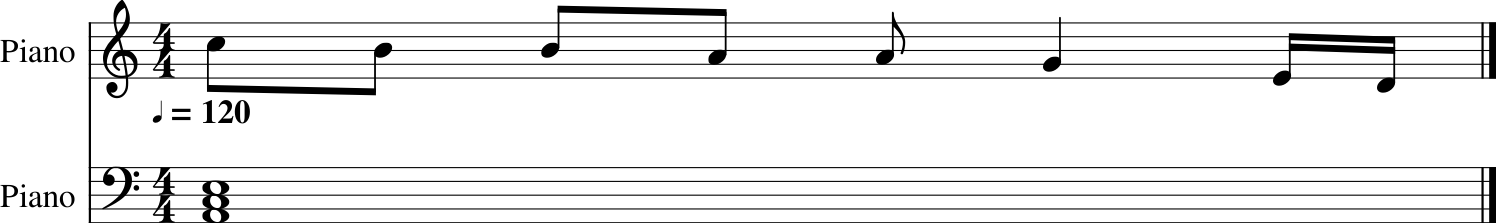

In [11]:
from pathlib import Path
midi_file = Path('../../data/midi/notebook_examples/single_bar_example.mid')
vocab = MusicVocab.create()
item = MusicItem.from_file(midi_file, vocab); item.show()

In [12]:
vocab.to_music_item(item.data)


MusicItem - (38,)
xxbos xxpad n72 d2 n52 d16 n48 d16 n45 d16...

In [13]:
#hide
from nbdev.export import notebook2script
notebook2script(recursive=True)

Converted config.ipynb.
Converted dataloader.ipynb.
Converted learner.ipynb.
Converted model.ipynb.
Converted transform.ipynb.
Converted dataloader.ipynb.
Converted learner.ipynb.
Converted model.ipynb.
Converted transform.ipynb.
Converted numpy_encode.ipynb.
Converted attention_mask.ipynb.
Converted env_setup.ipynb.
Converted file_processing.ipynb.
Converted lamb.ipynb.
Converted midifile.ipynb.
Converted stacked_dataloader.ipynb.
Converted top_k_top_p.ipynb.
Converted vocab.ipynb.
